In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

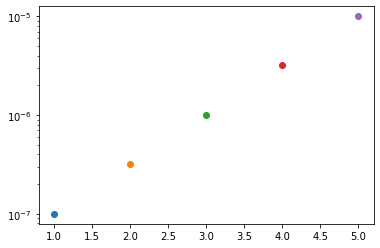

In [3]:
plt.scatter(1, 1e-7)
plt.scatter(2, 3.2e-7)
plt.scatter(3, 1e-6)
plt.scatter(4, 3.2e-6)
plt.scatter(5, 1e-5)
plt.yscale('log')

In [4]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [5]:
# define constants and other parameters
K = 1e-5 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [6]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 5
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [7]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

25000000.0


In [8]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

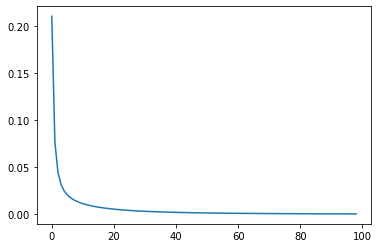

In [9]:
plt.plot(S)

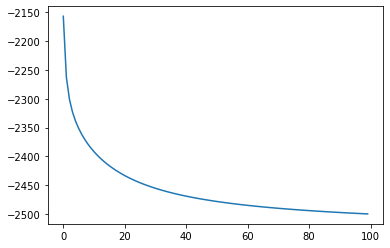

In [10]:
plt.plot(eta)

In [11]:
S[-1]

0.0005070048798479547

In [12]:
eta

array([-2157.39157128, -2262.71830783, -2301.07573751, -2323.24792501,
       -2339.00323551, -2351.40995514, -2361.74291945, -2370.64098528,
       -2378.46972191, -2385.4597228 , -2391.76753586, -2397.50562079,
       -2402.75840499, -2407.59151015, -2412.05736882, -2416.19881356,
       -2420.05146787, -2423.64539717, -2427.00628488, -2430.15629377,
       -2433.1147118 , -2435.89844701, -2438.52241368, -2440.9998387 ,
       -2443.34250822, -2445.56096864, -2447.6646924 , -2449.66221598,
       -2451.56125588, -2453.36880684, -2455.09122551, -2456.73430239,
       -2458.30332379, -2459.80312564, -2461.23814037, -2462.61243791,
       -2463.92976176, -2465.19356073, -2466.40701705, -2467.57307127,
       -2468.69444446, -2469.77365797, -2470.8130511 , -2471.81479698,
       -2472.78091671, -2473.71329226, -2474.61367793, -2475.48371082,
       -2476.32492022, -2477.1387362 , -2477.92649732, -2478.68945771,
       -2479.42879346, -2480.1456085 , -2480.84093993, -2481.51576288,
      

In [13]:
eta_adj = eta - eta[-1]

In [14]:
eta_adj

array([3.42008429e+02, 2.36681692e+02, 1.98324263e+02, 1.76152075e+02,
       1.60396765e+02, 1.47990045e+02, 1.37657081e+02, 1.28759015e+02,
       1.20930278e+02, 1.13940277e+02, 1.07632464e+02, 1.01894379e+02,
       9.66415953e+01, 9.18084901e+01, 8.73426315e+01, 8.32011867e+01,
       7.93485324e+01, 7.57546031e+01, 7.23937154e+01, 6.92437065e+01,
       6.62852885e+01, 6.35015533e+01, 6.08775866e+01, 5.84001616e+01,
       5.60574921e+01, 5.38390316e+01, 5.17353079e+01, 4.97377843e+01,
       4.78387444e+01, 4.60311934e+01, 4.43087748e+01, 4.26656979e+01,
       4.10966765e+01, 3.95968746e+01, 3.81618599e+01, 3.67875624e+01,
       3.54702385e+01, 3.42064395e+01, 3.29929832e+01, 3.18269290e+01,
       3.07055558e+01, 2.96263423e+01, 2.85869492e+01, 2.75852033e+01,
       2.66190836e+01, 2.56867080e+01, 2.47863223e+01, 2.39162895e+01,
       2.30750801e+01, 2.22612641e+01, 2.14735030e+01, 2.07105426e+01,
       1.99712068e+01, 1.92543918e+01, 1.85590604e+01, 1.78842374e+01,
      

In [15]:
# save csv files

np.savetxt('elevation csv files/eta_exp_4.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_4.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_4.csv', S, delimiter = ',')